# Classification of comments in online store.

Online store is launching a new service where users can edit and enhance product descriptions, similar to wiki communities. Customers suggest edits and comment on others' changes. The store needs a tool to detect toxic comments and send them for moderation.

**Task:** Train a model to classify comments as positive or negative.

**Data Description:** Text comments with toxicity labels.

## Data preparation.

### Data exploration.

#### Importing necessary libraries.

In [ ]:
!pip install transformers --quiet
!pip install torch --quiet

In [ ]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix


from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split


from tqdm import tqdm
from wordcloud import WordCloud


#### Reviewing file with labels.

##### Opening comments labeling file and saving it in a variable.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving toxic_comments.csv to toxic_comments (2).csv


In [ ]:
data = pd.read_csv("toxic_comments.csv", index_col=0)

##### Displaying 5 sample rows of the file.

In [ ]:
data.sample(5)

,text,toxic
142167,"Tell that to , who is reporting me. Thanks any...",0
118231,help \n\nDo you enjoy screwing your dog on a r...,0
29537,"Note: Now that I have an account, the IP talk ...",0
72681,Mills \n\nHeather Mills is a bitch. And Wikipe...,1
75968,and blocking any of these is just blocking use...,0


#####  Displaying basic information on dataset using the info() method.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


#####  Checking the class balance.

In [ ]:
# Counting the number of values in the target variable
class_counts = data['toxic'].value_counts()

print(class_counts)

0    143106
1     16186
Name: toxic, dtype: int64


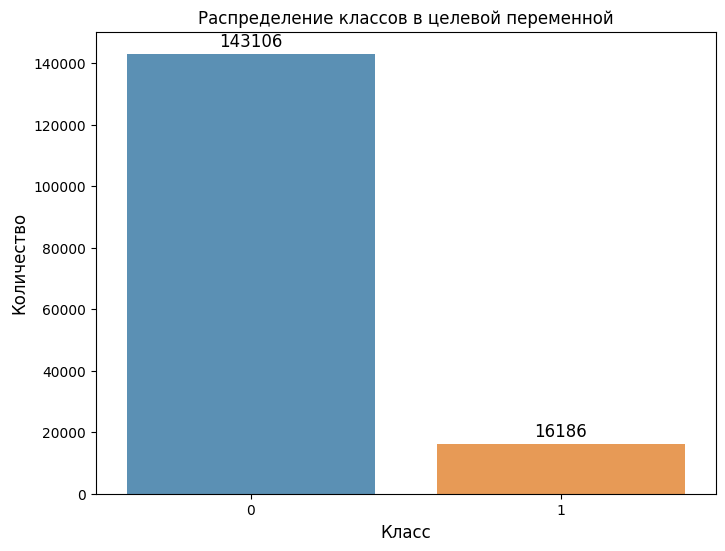

In [ ]:
# Plotting the distribution of classes in the target variable
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)
plt.title('Распределение классов в целевой переменной')
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Класс', fontsize=12)

# Adding counts above the bars
for p, label in zip(ax.patches, class_counts.values):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 9),
                 textcoords = 'offset points', fontsize=12)

plt.show()

The dataset is unbalanced with the number of negative comments being nearly 10 times smaller than the number of positive comments.

### Data preprocessing.

#### Extracting 2000 observations from the dataset with stratification based on the target feature.

In [ ]:
_, sample_data = train_test_split(data, stratify=data['toxic'], test_size=2000 / len(data), random_state=42)

#### Cleaning the text from unnecessary symbols.

In [ ]:
%%time
SPACES = r'([ ])\1+'
DOTS = r'[.]+'
SINGLE_WORD_IN_BRACKETS = r'\(.*?\)'
SPECIAL_CHARACTERS_IN_WORDS = r'\S*[:#]\S*'
IP_ADDRESSES = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
DATE_TIME = r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2}\b'
SINGLE_WORD_IN_BRACKETS = r'\(\w+\)'
UTC = r'\bUTC\b'
COMMA_BETWEEN_SPACES = r'\s,\s'
LETTERS = r'[^a-zA-Z\' ]'

def clean_text(text):
    txt = re.sub(IP_ADDRESSES, ' ', text)
    txt = re.sub(SINGLE_WORD_IN_BRACKETS, ' ', txt)
    txt = re.sub(DATE_TIME, ' ', txt)
    txt = re.sub(SPECIAL_CHARACTERS_IN_WORDS, ' ', txt)
    txt = re.sub(LETTERS, ' ', txt)
    txt = re.sub(UTC, ' ', txt)
    txt = re.sub(COMMA_BETWEEN_SPACES, ' ', txt)
    txt = re.sub(SPACES, ' ', txt)
    txt = re.sub(DOTS, '.', txt)
    txt = txt.encode('ascii', 'ignore').decode()
    txt = txt.strip()
    return txt.lower()

# applying tqdm
tqdm.pandas()

sample_data['cleaned_text'] = sample_data['text'].progress_apply(clean_text)

100%|██████████| 2000/2000 [00:00<00:00, 9020.31it/s]

CPU times: user 228 ms, sys: 1.11 ms, total: 229 ms
Wall time: 231 ms


In [ ]:
sample_data.reset_index(drop=True, inplace=True)


Checking the resulting outcome.

In [ ]:
print(sample_data['text'][0])

Yes you called us Böhmisches Volk. But after the rise of nationalism you started to call us Tschechen too negate the Czech history of this land.(85.0.2.33  )


In [ ]:
print(sample_data['cleaned_text'][0])

yes you called us b hmisches volk but after the rise of nationalism you started to call us tschechen too negate the czech history of this land


#### Creating and visualizing a word cloud.

In [ ]:
%%time
# Data preparation
toxic_comments = sample_data[sample_data['toxic'] == 1]
non_toxic_comments = sample_data[sample_data['toxic'] == 0]

# Combining all comments into one text
toxic_text = ' '.join(toxic_comments['cleaned_text'])
non_toxic_text = ' '.join(non_toxic_comments['cleaned_text'])

CPU times: user 4.49 ms, sys: 1 ms, total: 5.49 ms
Wall time: 7.77 ms


In [ ]:
%%time
# Создаем облака слов
toxic_wordcloud = WordCloud(width=800, height=400, background_color ='white', collocations=False).generate(toxic_text)
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color ='white', collocations=False).generate(non_toxic_text)

CPU times: user 1.26 s, sys: 34 ms, total: 1.29 s
Wall time: 1.33 s


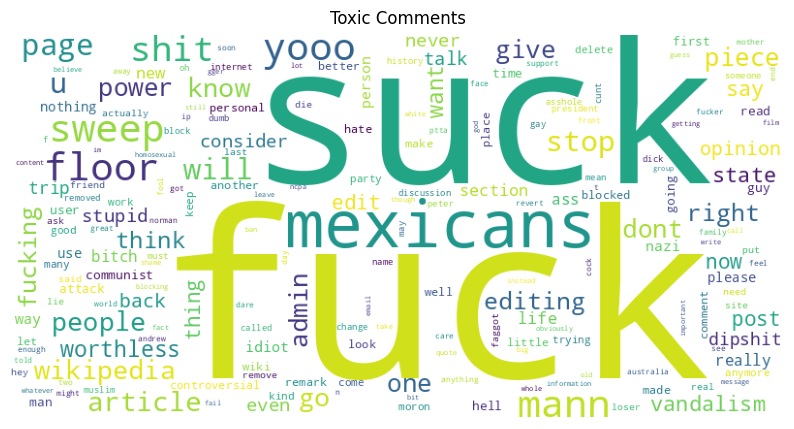

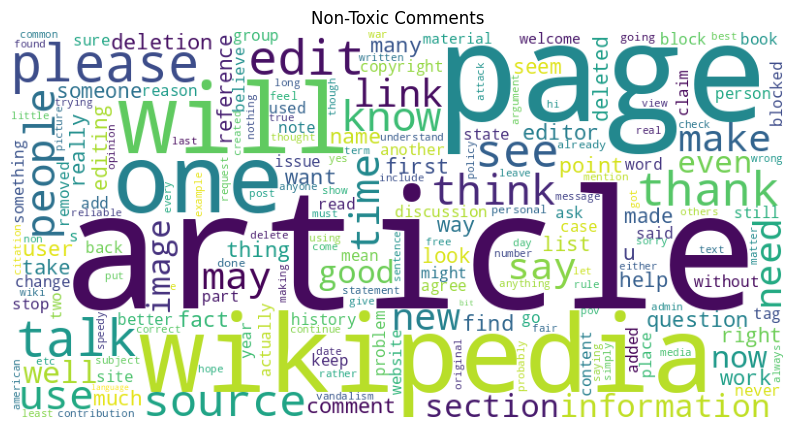

CPU times: user 825 ms, sys: 114 ms, total: 939 ms
Wall time: 974 ms


In [ ]:
%%time
# Displaying the word clouds
plt.figure(figsize=(10, 7))
plt.imshow(toxic_wordcloud)
plt.axis('off')
plt.title('Toxic Comments')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(non_toxic_wordcloud)
plt.axis('off')
plt.title('Non-Toxic Comments')
plt.show()

#### Creating embeddings for comments using BERT.

In [ ]:
# Loading the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # 0 and 1 (toxic and non-toxic)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
texts = sample_data['cleaned_text'].values

# Calculate the length of tokenized texts
token_lengths = []

for text in texts:
    tokens = tokenizer.tokenize(text)
    token_lengths.append(len(tokens))

# Calculate the average, median, and maximum length
avg_length = np.mean(token_lengths)
median_length = np.median(token_lengths)
max_length = np.max(token_lengths)

# Display statistics to choose the optimal embedding length
print(f"Средняя длина: {avg_length}")
print(f"Медианная длина: {median_length}")
print(f"Максимальная длина: {max_length}")

Средняя длина: 74.59
Медианная длина: 41.0
Максимальная длина: 1069


In [ ]:
# Embeddings creation
texts = sample_data['cleaned_text'].values
labels = sample_data['toxic'].values

input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

#### Splitting the embeddings into training, validation, and test sets.

In [ ]:
# Splitting the embeddings into training, validation, and test sets

train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(
    input_ids.numpy(), labels.numpy(), stratify=labels.numpy(), random_state=42, test_size=0.4
)

val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    temp_inputs, temp_labels, stratify=temp_labels, random_state=42, test_size=0.5
)

# Converting numpy arrays to tensors
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
test_inputs = torch.tensor(test_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

# Creating masks
train_masks, temp_masks, _, _ = train_test_split(
    attention_masks.numpy(), labels.numpy(), stratify=labels.numpy(), random_state=42, test_size=0.4
)

val_masks, test_masks, _, _ = train_test_split(
    temp_masks, temp_labels, stratify=temp_labels, random_state=42, test_size=0.5
)

# Converting numpy arrays back to tensors
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)
test_masks = torch.tensor(test_masks)

# Creating DataLoaders
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Training the BERT model.

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
best_f1 = 0

epochs = 3
for epoch in range(epochs):
    model.train()

    for batch in tqdm(train_dataloader, desc=f"Эпоха {epoch + 1} - Обучение"):
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask)[0]
        loss = criterion(outputs, b_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_preds = []
    val_true = []

    for batch in tqdm(val_dataloader, desc=f"Эпоха {epoch + 1} - Валидация"):
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)[0]

        preds = torch.argmax(outputs, dim=1).flatten()
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(b_labels.cpu().numpy())

    f1 = f1_score(val_true, val_preds)
    print(f'Эпоха {epoch + 1}, Метрика F1 на валидации: {f1}')

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_bert_toxic.bin')

Эпоха 1 - Валидация: 100%|██████████| 13/13 [02:18<00:00, 10.66s/it]


Эпоха 1, Метрика F1 на валидации: 0.975


Эпоха 2 - Валидация: 100%|██████████| 13/13 [02:23<00:00, 11.06s/it]


Эпоха 2, Метрика F1 на валидации: 0.9647058823529412


Эпоха 3 - Валидация: 100%|██████████| 13/13 [02:23<00:00, 11.01s/it]

Эпоха 3, Метрика F1 на валидации: 0.975


**Conclusion:** The model achieved an excellent performance with a high value of the target metric.

## Testing the Bert model.

In [ ]:
model.load_state_dict(torch.load('best_bert_toxic.bin'))
model.eval()

test_preds = []
test_true = []

for batch in tqdm(test_dataloader):  # обернул test_dataloader в tqdm
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)[0]

    preds = torch.argmax(outputs, dim=1).flatten()
    test_preds.extend(preds.cpu().numpy())
    test_true.extend(b_labels.cpu().numpy())

print("Метрика F1 на тестовой выборке:", f1_score(test_true, test_preds))

100%|██████████| 13/13 [03:08<00:00, 14.50s/it]

Метрика F1 на тестовой выборке: 0.9382716049382716


Creation and visualization of confusion matrix.

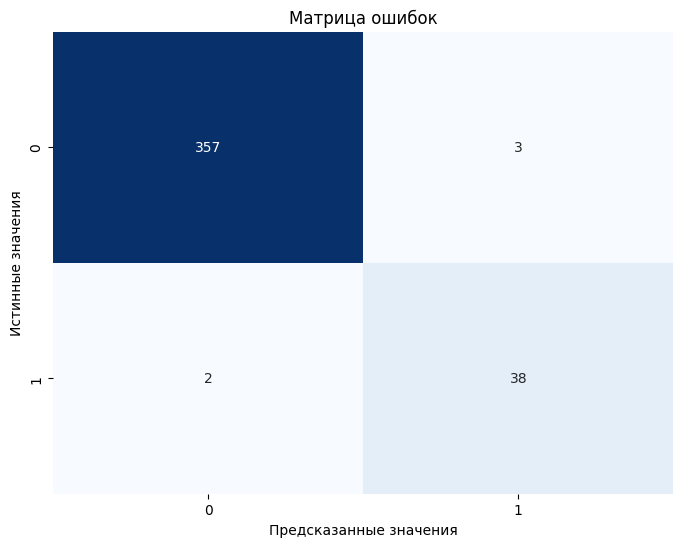

In [ ]:
cm = confusion_matrix(test_true, test_preds)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

## Project summary report.

A dataset consisting of nearly 160,000 comment texts and labels indicating their toxicity was provided for the project. The dataset was imbalanced, with toxic comments being almost 10 times less frequent than non-toxic ones.

After data exploration and the creation of a subsample of 2,000 observations, the following preprocessing steps were performed:

- Cleaning of the text in order to remove unnecessary symbols using regular expressions.
- Generating embeddings using the BERT model.
The BERT model demonstrated outstanding performance during training and validation stages, achieving an F1 score of up to 0.97.

This exceptional performance was further confirmed on the test dataset.